# Quantum Evolution Kernal for Earth Observation
This notebook uses `qutip` as a backend for running the simulations. It can be run locally.

In [1]:
import qsvm4eo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the data
num_features = 4
x_train, y_train, x_test, y_test, label_names = qsvm4eo.load_data(
    data_path="..", num_features=num_features, scale_features=False
)

# Encode the data, transforming the features into qubit coordinates
encoding = qsvm4eo.RadialEncoding(
    max_feature=np.max(x_train), shift=1.0, scaling=5.4, n_features=num_features
)
qbits_train = [encoding.encode(x) for x in x_train]
qbits_test = [encoding.encode(x) for x in x_test]

print("Qubit Geometries:")
print(qbits_train[:4])

Qubit Geometries:
[array([[ 6.49087678e+00,  0.00000000e+00],
       [ 4.35649236e-16,  7.11469194e+00],
       [-7.33116114e+00,  8.97808302e-16],
       [-1.63603526e-15, -8.90616114e+00]]), array([[ 6.27760664e+00,  0.00000000e+00],
       [ 4.00259265e-16,  6.53672986e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.35225118e+00,  0.00000000e+00],
       [ 4.10380013e-16,  6.70201422e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.30959716e+00,  0.00000000e+00],
       [ 4.07898797e-16,  6.66149289e+00],
       [-7.11895735e+00,  8.71820833e-16],
       [-1.61409609e-15, -8.78672986e+00]])]


In [3]:
qpu_qutip = qsvm4eo.QutipBackend()
probs_train = qpu_qutip.batch(qbits_train)
probs_test = qpu_qutip.batch(qbits_test)

In [4]:
excitations_train = qsvm4eo.compute_excitation_count(probs_train)
excitations_test = qsvm4eo.compute_excitation_count(probs_test)

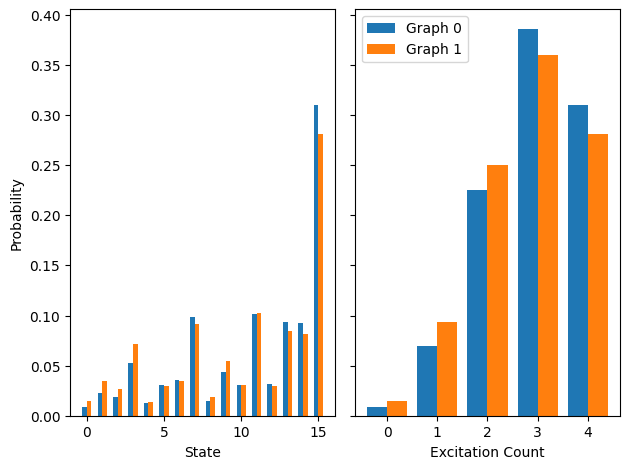

In [5]:
# Plot the probability of the states being measured
fig, axs = plt.subplots(ncols=2, sharey="row")

x = np.arange(num_features**2)
width = 0.3
for c in range(2):
    axs[0].bar(x+(2*c-1)*width*0.5, probs_train[c], width=width, label="Graph %i" % c)
axs[0].set_xlabel("State")
axs[0].set_ylabel("Probability")

# Plot the probability of the states being measured
x = np.arange(num_features+1)
width = 0.4
for c in range(2):
    axs[1].bar(x+(2*c-1)*width*0.5, excitations_train[c], width=width, label="Graph %i" % c)
axs[1].set_xlabel("Excitation Count")
axs[1].legend()

plt.tight_layout()
plt.show()

# Train SVC

In [6]:
# Compute the kernel
kernel = qsvm4eo.Kernel()
gram_train = kernel.compute_gram_train(excitations_train)

# Fit the SVM and get the score
model = SVC(kernel="precomputed")
model.fit(gram_train, y_train)
train_score = model.score(gram_train, y_train)

# Compute the kernel and score for the test data
gram_test = kernel.compute_gram_test(excitations_test, excitations_train)
test_score = model.score(gram_test, y_test)
y_test_pred = model.predict(gram_test)

print("Train acc:", train_score)
print("Test acc:", test_score)

Train acc: 0.7578125
Test acc: 0.5107421875


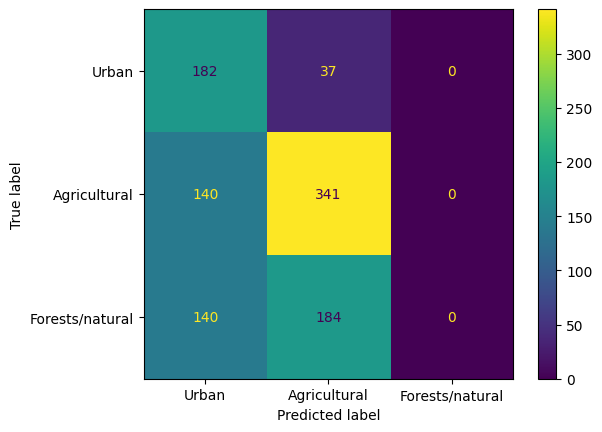

In [7]:
conf_mat = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names.values())
disp.plot()
plt.show()